# Analyze gha Commits

In [19]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import pandas as pd
from tqdm import tqdm
import git 
import os
import shutil
import stat
import re
from scipy.stats import kendalltau, spearmanr

## Generate info on commits, projects and authors
In this step, we will use the **GitPython** package.

In [22]:
columns_to_read = list(range(5))
df = pd.read_csv('C:\\paper\\empirical_analysis\\data\\RQ4\\cleaned_ci_modifying_commits.csv', usecols=columns_to_read)
df = df.dropna(subset=['projectname', 'commitid'], how='all')
total_rows = len(df)

print(f"Total number of rows in the Excel file: {total_rows}")

Total number of rows in the Excel file: 23349


In [23]:
# workaround for windows
def remove_readonly(func, path, excinfo):
    os.chmod(path, stat.S_IWRITE)
    func(path)

In [24]:
def get_commit_df(project_series, commits_series, start, total_iterations, commit_df, project_df, author_df):

    last_project = ''
    temp_dir = ''

    with tqdm(total=total_iterations-start, desc=f"Processing commits from {start} to {total_iterations}") as pbar:

        for i in range(start, total_iterations):
        
            project = project_series[i]
            commit_sha = commits_series[i]
            repo_url = f'https://github.com/{project}.git'
            
            try:                 
                if last_project != project:
                    if last_project != '':
                        repo.close()
                        if os.path.exists(temp_dir):
                            shutil.rmtree(temp_dir, onerror=remove_readonly)
                    temp_dir = f'{project.split("/")[1]}'
                    last_project = project
                    repo = git.Repo.clone_from(repo_url, temp_dir)
                
                
                total_commits = len(list(repo.iter_commits('HEAD')))

                repo.git.checkout(commit_sha)
                commit = repo.commit(commit_sha)
                author_name = commit.author.name
                author_email = commit.author.email
                commit_message = ''
                

                try:
                    # this will generate an exception if the file is deleted or added 
                    diff_output = repo.git.diff('--shortstat', commit.parents[0], commit_sha, '.github/workflows/*.yml')
                    insertion_match = re.search(r'(\d+) insertion', diff_output)
                    deletion_match = re.search(r'(\d+) deletion', diff_output)
                    additions = int(insertion_match.group(1)) if insertion_match else 0
                    deletions = int(deletion_match.group(1)) if deletion_match else 0
                except Exception as e: 
                    # just use these default values
                    additions = 0
                    deletions = 0

                new_row = {
                    'project': project, 'commit_sha': commit_sha, 'commit_message': commit_message,
                    'loc_modified': additions + deletions, 'loc_added': additions, 'loc_deleted': deletions, 
                    'author_email': author_email, 'author_name': author_name
                    }
                commit_df =  pd.concat([commit_df, pd.DataFrame([new_row])], ignore_index=True)
            
            except Exception as e:
                print(f'{i} - project: {project} - commit: {commit_sha}')
                print(f'Error: {e}')
                continue

        
            try:
                # ------------------------------------------- project
                project_to_update = project_df.loc[project_df['project'] == project]
                if project_to_update.empty:
                    project_df =  pd.concat([project_df, pd.DataFrame([{'project': project, 'total_commits': total_commits, 'gha_commits': 1 }])], ignore_index=True)
                else:
                    project_df.loc[project_to_update.index, 'gha_commits'] += 1
                
                project_row = project_df[project_df['project'] == project]
                author_df.loc[author_df['project'] == project, 'gha_project_commits'] = project_row['gha_commits'].values[0]
                
                # ------------------------------------------- author
                author_to_update = author_df.loc[(author_df['author_email'] == author_email) & (author_df['project'] == project)]
                project_row = project_df[project_df['project'] == project]
                if author_to_update.empty:
                    command = f'git rev-list --count --author="{author_email}" HEAD'
                    commit_count = int(repo.git.execute(command).strip())
                    author_df =  pd.concat([author_df, pd.DataFrame([{
                        'author_email': author_email, 'author_name' : author_name, 'project': project, 
                        'loc_modified': additions + deletions, 'loc_added': additions, 'loc_deleted': deletions, 
                        'total_author_commits': commit_count, 'gha_author_commits': 1, 
                       'total_project_commits': project_row['total_commits'].values[0] , 
                        'gha_project_commits': project_row['gha_commits'].values[0]
                        }])], ignore_index=True)
                    
                else:
                    author_df.loc[author_to_update.index, 'gha_author_commits'] += 1
                    author_df.loc[author_to_update.index, 'loc_modified'] += additions + deletions
                    author_df.loc[author_to_update.index, 'loc_added'] += additions
                    author_df.loc[author_to_update.index, 'loc_deleted'] += deletions
            
            except Exception as e:
                print(f'Error: {e}')
                    
            pbar.update(1)

    # Remove repo for the last one
    if os.path.exists(temp_dir):
        repo.close()
        shutil.rmtree(temp_dir, onerror=remove_readonly)    
    
    return (commit_df, project_df, author_df)

In [25]:
def generate_excel_file_with_information(project_series, commits_series, start, total_iterations):
    file_path = f'C:\\paper\\empirical_analysis\\data\\RQ4\\RQ4_developer_expertise_2.xlsx'

    # if we already analyzed other commits -> append to that list
    if start > 0 :
        commit_df = pd.read_excel(file_path, sheet_name='commit_df', index_col=0)
        project_df = pd.read_excel(file_path, sheet_name='project_df', index_col=0)
        author_df = pd.read_excel(file_path, sheet_name='author_df', index_col=0)
        
    else:
        commit_df = pd.DataFrame(columns=[
        'project', 'commit_sha',
        'loc_modified', 'loc_added','loc_deleted', 
        'author_email', 'author_name'
        ])
        project_df = pd.DataFrame(columns=['project', 'total_commits', 'gha_commits'])
        author_df = pd.DataFrame(columns=[
            'author_email', 'author_name', 'project', 
            'loc_modified', 'loc_added','loc_deleted', 
            'total_author_commits', 'gha_author_commits', 
            'total_project_commits', 'gha_project_commits'
            ])
    
    (commit_df, project_df, author_df) = get_commit_df(project_series, commits_series, start, total_iterations, commit_df, project_df, author_df)

    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        commit_df.to_excel(writer, sheet_name='commit_df', index=True)
        project_df.to_excel(writer, sheet_name='project_df', index=True)
        author_df.to_excel(writer, sheet_name='author_df', index=True)

In [26]:
project_series = df['projectname'].astype(str)
commits_series = df['commitid'].astype(str)



start = 0
total_iterations = 1000

# Do this in 1000 increments in case an error occures, that way we don't lose all data
for i in range (51):
    generate_excel_file_with_information(project_series, commits_series, start, total_iterations)
    start += 1000
    total_iterations += 1000

Processing commits from 3000 to 4000:  24%|██▍       | 239/1000 [02:38<05:38,  2.25it/s] 

3239 - project: OpenMined/PySyft - commit: 48ca7a6a50978bab9eccadca2ca1a6f213273acc
Error: Cmd('git') failed due to: exit code(1)
  cmdline: git checkout 48ca7a6a50978bab9eccadca2ca1a6f213273acc
  stderr: 'error: invalid path 'packages/grid/frontend/public/assets/card_image.jpg:Zone.Identifier''


Processing commits from 3000 to 4000:  42%|████▏     | 420/1000 [04:16<04:43,  2.04it/s]

3421 - project: OpenMined/PySyft - commit: 7dd4f074c8b698d36d7e75a502b00fd94a2ee3c9
Error: Cmd('git') failed due to: exit code(1)
  cmdline: git checkout 7dd4f074c8b698d36d7e75a502b00fd94a2ee3c9
  stderr: 'error: invalid path 'Python:''


Processing commits from 6000 to 7000:  25%|██▍       | 247/1000 [01:46<02:04,  6.05it/s] 

6247 - project: alan-turing-institute/MLJ.jl - commit: bf7606ada97757f97c70e081406581ae33060281
Error: Cmd('git') failed due to: exit code(1)
  cmdline: git checkout bf7606ada97757f97c70e081406581ae33060281
  stderr: 'error: invalid path 'docs/src/_old/
workflows_learning_curves.png''
6248 - project: alan-turing-institute/MLJ.jl - commit: 9114c0cef56181168b8850e2f4de9237b1a7ed18
Error: Cmd('git') failed due to: exit code(1)
  cmdline: git checkout 9114c0cef56181168b8850e2f4de9237b1a7ed18
  stderr: 'error: invalid path 'docs/src/
workflows_learning_curves.png''
6249 - project: alan-turing-institute/MLJ.jl - commit: 3b369ffb9c5b6a908a64b9eef97ed0bd639d58d4
Error: Cmd('git') failed due to: exit code(1)
  cmdline: git checkout 3b369ffb9c5b6a908a64b9eef97ed0bd639d58d4
  stderr: 'error: invalid path 'docs/src/
workflows_learning_curves.png''


Processing commits from 7000 to 8000:  11%|█         | 110/1000 [01:33<37:18,  2.52s/it]  

7110 - project: dice-group/LIMES - commit: dcae65134498b42e9c04821d8eb496feb7145f46
Error: Cmd('git') failed due to: exit code(1)
  cmdline: git checkout dcae65134498b42e9c04821d8eb496feb7145f46
  stderr: 'error: Your local changes to the following files would be overwritten by checkout:
	limes-core/src/test/java/org/aksw/limes/core/measures/mapper/topology/RADONTest.java
Please commit your changes or stash them before you switch branches.
Aborting'
7111 - project: dice-group/LIMES - commit: a3503f89e93f82950514aa221f52d844e6592df9
Error: Cmd('git') failed due to: exit code(1)
  cmdline: git checkout a3503f89e93f82950514aa221f52d844e6592df9
  stderr: 'error: Your local changes to the following files would be overwritten by checkout:
	limes-core/src/test/java/org/aksw/limes/core/measures/mapper/topology/RADONTest.java
Please commit your changes or stash them before you switch branches.
Aborting'
7112 - project: dice-group/LIMES - commit: ef7fb12a0adbf9df74475c9cb545afa7387ed11c
Error: C

Processing commits from 7000 to 8000:  15%|█▍        | 146/1000 [01:47<03:24,  4.17it/s]

7150 - project: dmlc/xgboost - commit: c69c4adb584e958878fc4b8aa2f0a201960af8d9
Error: [WinError 32] The process cannot access the file because it is being used by another process: 'gluon-cv\\docs\\tutorials\\datasets'
7151 - project: dmlc/xgboost - commit: ec8cfb326734a651d89df681eb1da2235436860f
Error: [WinError 32] The process cannot access the file because it is being used by another process: 'gluon-cv\\docs\\tutorials\\instance'


Processing commits from 8000 to 9000:  52%|█████▏    | 517/1000 [04:00<03:24,  2.37it/s]  

8517 - project: huggingface/pytorch-pretrained-BERT - commit: 656d41ab4c05f30790b663accd1f9c9b60b5fa12
Error: Cmd('git') failed due to: exit code(1)
  cmdline: git checkout 656d41ab4c05f30790b663accd1f9c9b60b5fa12
  stderr: 'error: Your local changes to the following files would be overwritten by checkout:
	docs/source/ko/tasks/translation.mdx
Please commit your changes or stash them before you switch branches.
Aborting'
8518 - project: huggingface/pytorch-pretrained-BERT - commit: 2c22bc79c28feab9070e9c4e25c8577e0d05be8e
Error: Cmd('git') failed due to: exit code(1)
  cmdline: git checkout 2c22bc79c28feab9070e9c4e25c8577e0d05be8e
  stderr: 'error: Your local changes to the following files would be overwritten by checkout:
	docs/source/ko/tasks/translation.mdx
Please commit your changes or stash them before you switch branches.
Aborting'
8519 - project: huggingface/pytorch-pretrained-BERT - commit: 0fe6c6bdca79cab648c84e0d605469c8456e02ce
Error: Cmd('git') failed due to: exit code(1)
 

Processing commits from 15000 to 16000:  31%|███       | 307/1000 [02:51<03:05,  3.74it/s]  

15307 - project: ParsianRoboticLab/Zero-Shot-Learning - commit: 02c165a1e4bbac489dcb44ee106c28651309b645
Error: [WinError 32] The process cannot access the file because it is being used by another process: 'OpenNMT-py'


Processing commits from 15000 to 16000:  85%|████████▌ | 850/1000 [06:30<00:47,  3.19it/s]  

15851 - project: SeldonIO/seldon-core - commit: cce1110c261eddfca054d63d72304f64deed4b3b
Error: Cmd('git') failed due to: exit code(1)
  cmdline: git checkout cce1110c261eddfca054d63d72304f64deed4b3b
  stderr: 'error: invalid path 'doc/source/images/adversarial-attack.png:Zone.Identifier'
error: invalid path 'doc/source/images/anchors.jpg:Zone.Identifier'
error: invalid path 'doc/source/images/kibana-custom-search.png:Zone.Identifier''
15852 - project: SeldonIO/seldon-core - commit: a73deaa72c52158e32d2ac3f15ff8a3a30231864
Error: Cmd('git') failed due to: exit code(1)
  cmdline: git checkout a73deaa72c52158e32d2ac3f15ff8a3a30231864
  stderr: 'error: invalid path 'doc/source/images/adversarial-attack.png:Zone.Identifier'
error: invalid path 'doc/source/images/anchors.jpg:Zone.Identifier'
error: invalid path 'doc/source/images/kibana-custom-search.png:Zone.Identifier''
15853 - project: SeldonIO/seldon-core - commit: 7c7b871293e1b984b7d77da87211152076b02f04
Error: Cmd('git') failed due to

Processing commits from 17000 to 18000:  73%|███████▎  | 728/1000 [05:12<21:07,  4.66s/it]  

17728 - project: feedzai/feedzai-openml - commit: 3d1235f5bcaf79c70a920fe61d2f82e067112758
Error: [WinError 32] The process cannot access the file because it is being used by another process: 'majiang_algorithm\\majiang_clien_normal.txt'
17729 - project: feedzai/feedzai-openml-r - commit: b6359147ce1c7182843a7d88d33f8c0742f434d0
Error: [WinError 32] The process cannot access the file because it is being used by another process: 'majiang_algorithm\\majiang_server_normal.txt'
17730 - project: felixriese/susi - commit: 4a913da80fbb372779d078bddb0ff1d79141c0b5
Error: [WinError 32] The process cannot access the file because it is being used by another process: 'majiang_algorithm\\majiang_server_normal.txt'
17731 - project: felixriese/susi - commit: f3c62cd3b93fec0c25e9a6c90afe500970a32e6b
Error: [WinError 32] The process cannot access the file because it is being used by another process: 'majiang_algorithm\\majiang_server_normal.txt'


Processing commits from 19000 to 20000:  27%|██▋       | 268/1000 [02:02<17:45,  1.46s/it]  

19268 - project: madsjulia/Mads.jl - commit: 546fde3e2154a9e76721159f5930884208807046
Error: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/madsjulia/Mads.jl.git Mads.jl
  stderr: 'Cloning into 'Mads.jl'...
POST git-upload-pack (185 bytes)
POST git-upload-pack (gzip 11227 to 5657 bytes)
error: unable to create symlink examples/model_analysis/models/internal-polynomial.jl: Filename too long
error: unable to create symlink examples/model_analysis/models/internal-polynomial.mads: Filename too long
error: unable to create symlink examples/model_coupling/external-linearmodel-ascii.mads: Filename too long
error: unable to create symlink examples/model_coupling/external-linearmodel-jld.jl: Filename too long
error: unable to create symlink examples/model_coupling/external-linearmodel-jld.mads: Filename too long
error: unable to create symlink examples/model_coupling/external-linearmodel-jld2.jl: Filename too long
error: unable to create symlink examples/

Processing commits from 20000 to 21000: 100%|██████████| 1000/1000 [13:40<00:00,  1.22it/s] 


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'webots'

# Calculate Correlations between author git commits and their total contribution to the project

In [33]:
file_path_1 = f'C:\\paper\\empirical_analysis\\data\\RQ4\\RQ4_developer_expertise_2.xlsx'
df = pd.read_excel(file_path_1, sheet_name='author_df')
df.dropna(inplace=True)

In [34]:
percentage_gha_commits = "Percentage of Git commits per author"
percentage_commits = "Percentage of total commits per author"

In [35]:
# Convert data to numeric if needed
df[percentage_gha_commits] = pd.to_numeric(df[percentage_gha_commits], errors='coerce')
df[percentage_commits] = pd.to_numeric(df[percentage_commits], errors='coerce')

In [36]:
correlation = df[percentage_commits].corr(df[percentage_gha_commits])
print(f"Pearson correlation coefficient: {correlation}")

spearman_corr, spearman_pvalue  = spearmanr(df[percentage_commits ], df[percentage_gha_commits])
print(f"Spearman's correlation coefficient: {spearman_corr}")
print(f"Spearman's p-value: {spearman_pvalue}")


kendall_corr, kendall_pvalue  = kendalltau(df[percentage_commits ], df[percentage_gha_commits])
print(f"Kendall's correlation coefficient: {kendall_corr}")
print(f"Spearman's p-value: {kendall_pvalue}")


Pearson correlation coefficient: 0.758293318125204
Spearman's correlation coefficient: 0.7443371826533868
Spearman's p-value: 5.2199e-319
Kendall's correlation coefficient: 0.5619358128825904
Spearman's p-value: 1.928518118205453e-278


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


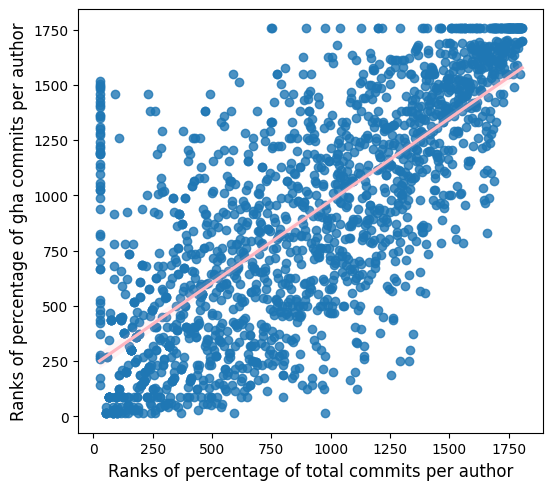

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata


x = df[percentage_commits]
y = df[percentage_gha_commits]

# Calculate ranks
x_rank = rankdata(x)
y_rank = rankdata(y)

plt.figure(figsize=(6, 5.5))
# Scatter plot with regression line
sns.regplot(x=x_rank, y=y_rank, line_kws={"color": "lightpink"})

# Set plot labels and title
plt.xlabel('Ranks of percentage of total commits per author', fontsize=12)
plt.ylabel('Ranks of percentage of gha commits per author', fontsize=12)

plt.savefig('figures/rq4_correlation.eps', format='eps', bbox_inches='tight')
plt.show()
